In [3]:
options(repr.plot.width=15, repr.plot.height=8)

suppressMessages(library(mongolite))
suppressMessages(library(tidyverse))
suppressMessages(library(quanteda))
suppressMessages(library(lubridate))
suppressMessages(library(gridExtra))

## Sentiment Analysis of German federal election 2017

How did the German federal election 2017 play out on Twitter?

We provide a short tweet and sentiment analysis that depicts:

- how many tweets were released over time (by party accounts).
- which accounts were most retweeted.
- and which tone tweets by different party accounts had.

We use the sample German federal election dataset by Stier et al. (2018). It provides tweets by various accounts related to the last hours of the German federal Election in 2017 and ranges from the 23st of September 2017 at 8pm to the 24th of September until 2pam.


In [4]:
collection <- "politicians_sample" # or "organizations" "selectors"
username <- "btw17_public_user"
password <- "btw17_public"
ip <- "10.6.13.55"
db = "twitter_public"
     

In [5]:
m <- mongo(collection = collection, url =
             paste0('mongodb://',username,':',password,'@',ip,'/',db))

In [6]:
df <- m$find(
  query = '{
 }',
  fields = '{"_id": 1, "user.id": 1, "user.name": 1, "user.screenName": 1, "createdAt": 1, "text": 1, "source": 1}'
)


# create party information
df <- df %>%
    mutate(account_by_party = case_when(grepl("afd",tolower(user$screenName)) ~ "AfD",
                    grepl("cdu|csu",tolower(user$screenName)) ~ "CDU/CSU",
                    grepl("gruen|grün",tolower(user$screenName)) ~ "Greens",
                    grepl("spd",tolower(user$screenName)) ~ "SPD",
                    grepl("fdp",tolower(user$screenName)) ~ "FDP",
                    grepl("linke",tolower(user$screenName)) ~ "Left party",
                    TRUE ~ "other"))

### How many tweets were released over time (by party accounts)

How many tweets are in the dataset and how did tweeting behaviour change with time? And how did parties behave in their tweeting strategies over time?

The upper plot below shows the number of tweets that users released during the time of our analysis, summed up by hour. Overall, the datset comprises of 10,000 tweets, tha majority of which users released between 9pm and 11pm. The plot shows how users increasingly stopped tweeting after 12pm, indicating the increased amount of sleeping people.

The lower plot depicts the same development for accounts containing the names of the different parties in the election.

In [7]:
# enter 'hour', 'minute', 'day' etc. to select the temporal granularity of number of tweets.

time <- "hour"

df_notweets <- df %>%
    mutate(date = round_date(createdAt, time)) %>%
    group_by(date) %>%
    summarise(n = n())

df_notweets_party <- df %>%
    mutate(date = round_date(createdAt, time)) %>%
    group_by(date, account_by_party) %>%
    summarise(n = n()) %>%
    filter(account_by_party != "other")

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.


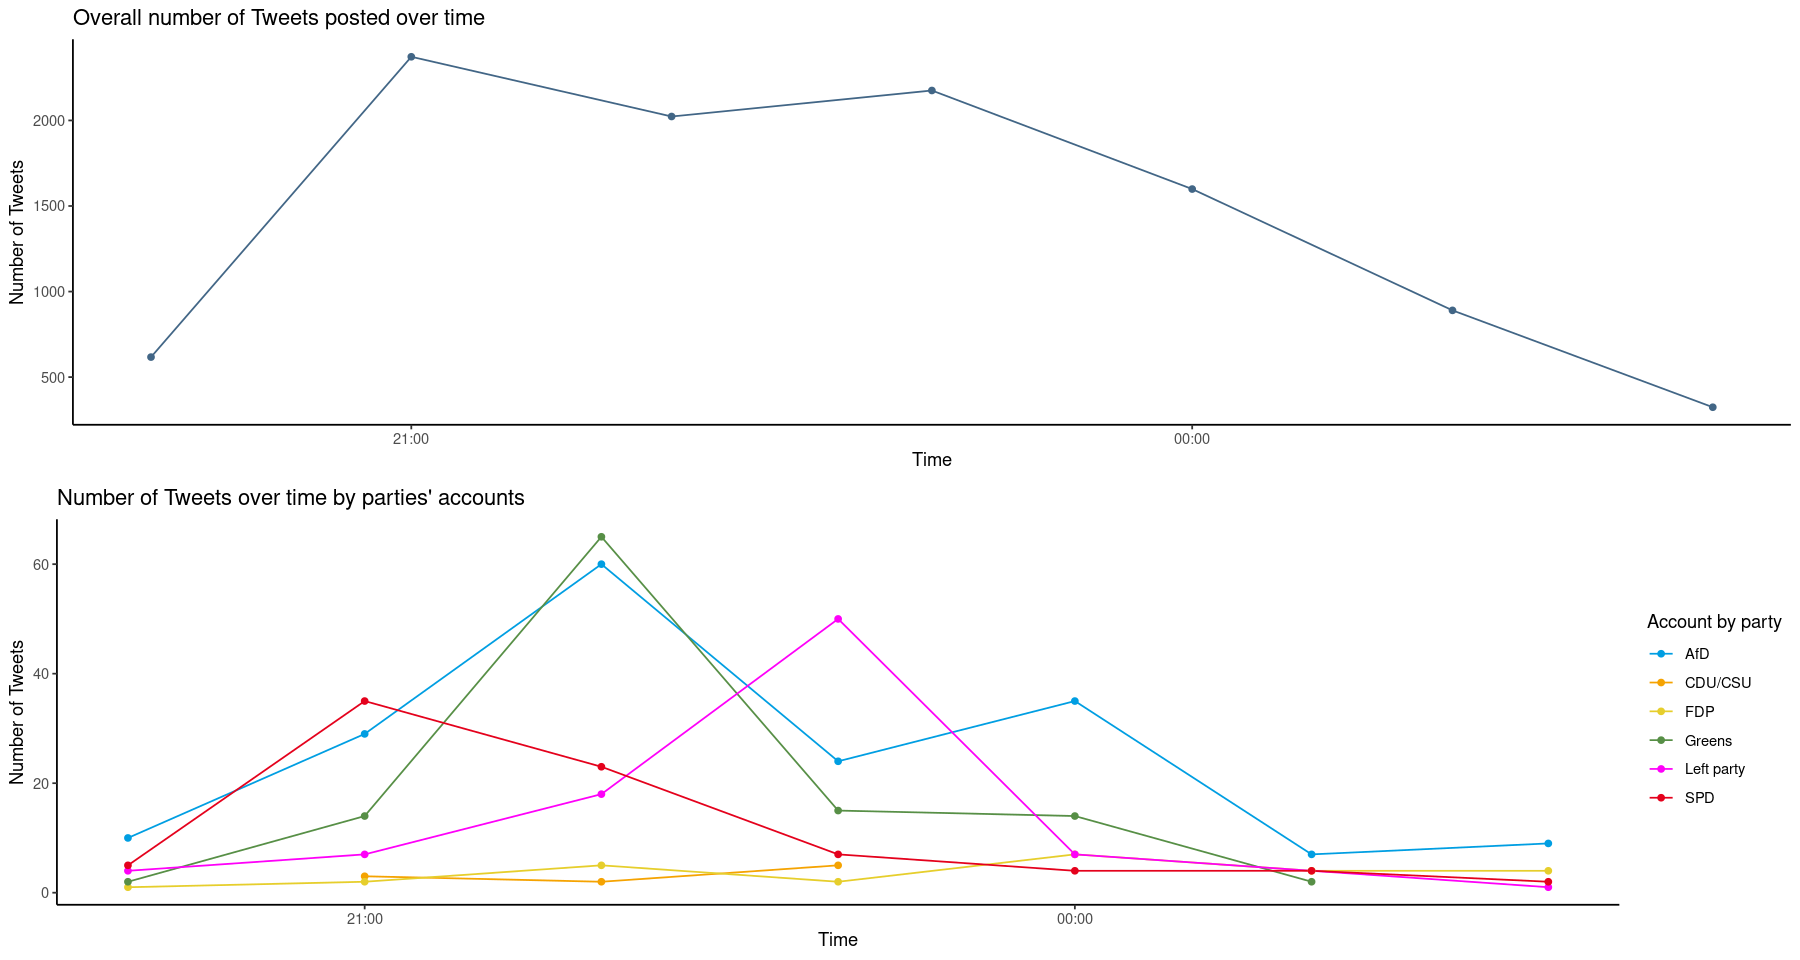

In [8]:
a <- ggplot(data = df_notweets, aes(x = date,
                               y = n))+
       geom_line(color = "#426686")+
        geom_point(color = "#426686")+
       labs(title = "Overall number of Tweets posted over time",
            x = "Time",
            y = "Number of Tweets")+
        theme_classic()

b <- ggplot(data = df_notweets_party, aes(x = date,
                               y = n,
                               color = account_by_party))+
geom_line()+
geom_point()+
labs(title = "Number of Tweets over time by parties' accounts",
     x = "Time",
     y = "Number of Tweets",
    color = "Account by party")+
theme_classic()+
scale_color_manual(values = c("#009EE2", "#F5A301", "#E6CE2C", "#578F46", "#FE00F9", "#E4011C"))

grid.arrange(a,b,ncol = 1)

In [9]:
## Accounts with most retweets over time:

df$retweet <- ifelse(grepl("^RT ", df$text), 1, 0) 
#table(df$retweet

### Which accounts were most retweeted?

How did users react to different accounts? In which accounts generated the most reactions in the form of retweets?

The bar plot below depicts the 20 most frequently retweeted accounts and indicates the number of retweets mentioning these accounts. Accounts by or mentioning the AfD generally make up the largest part of the Top 20 most retweeted accounts, which gives a first indication of the influence the AfD and its accounts have on Twitter.

In [103]:
retweet_df <- df %>%
    filter(retweet == 1) %>%
    mutate(retweet_to = str_extract(text, "(?<=@).+?(?=\\W)"))


get_sample_tweet <- function(text_column, n = 1){
    sample_tweet <- sample(text_column,n)
    return(sample_tweet)
}

retweet_count <- retweet_df %>%
    group_by(retweet_to) %>%
    summarise(n = n(),
             sample_tweet = get_sample_tweet(text, 1)) %>%
    arrange(desc(n)) %>%
    head(20) 

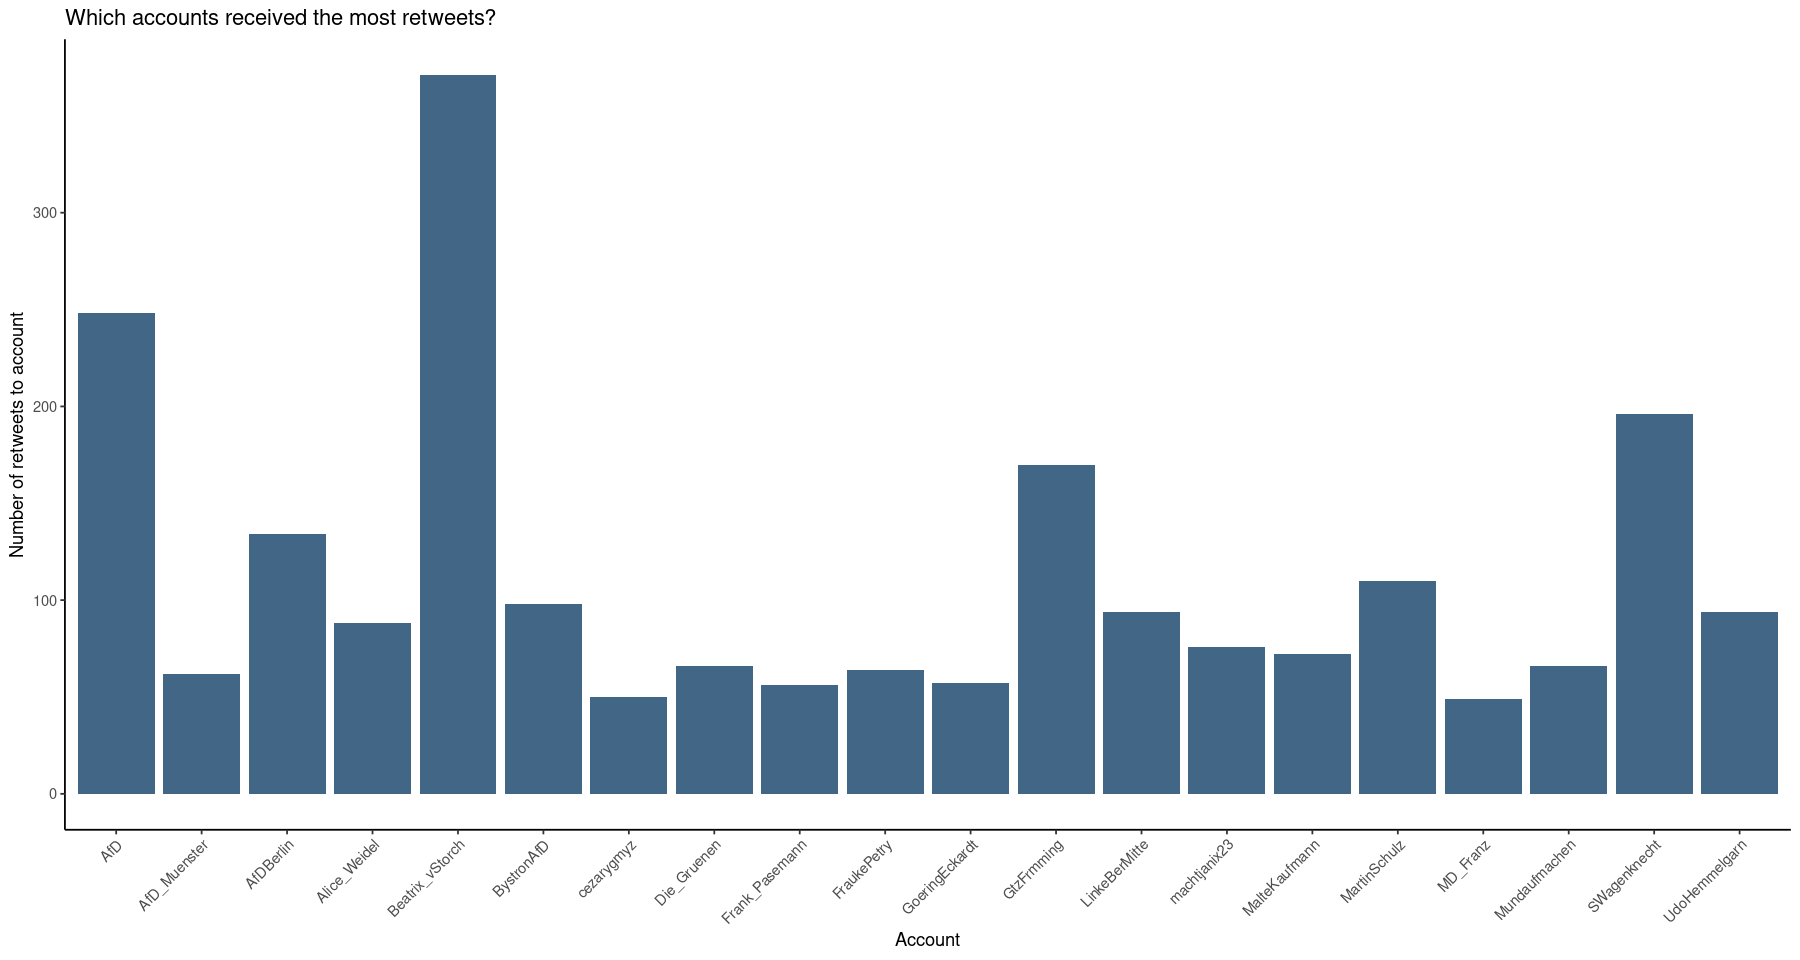

In [121]:
ggplot(data = retweet_count, aes(x = retweet_to, y = n))+
    geom_bar(fill = "#426686", stat = "identity")+
    labs(x = "Account",
         y = "Number of retweets to account",
         title = "Which accounts received the most retweets?")+
    theme_classic()+
    theme(axis.text.x = element_text(angle = 45, hjust = 1))


### Sentiment analysis: how did the tone in tweets by different party accounts differ?

We analysed how sentiment in tweets differed by different party accounts and other users.

We calculated sentiment scores by using the Sentiment dictionary by Remus et al. (2010) and summed up negative and postiive sentiments per interested subgroup of our population. 

To account for different numbers of tweets by subgroup that may influence the overall sentiment score, we calculated sentiment scores per tweet by dividing an overall sentiment score by the number of observations in a subgroup.


In [10]:
source("text_to_sentiment.R")

df_parties <- df %>%
    group_by(account_by_party) %>%
    summarise(n = n(),
              overall_sentiment = text_to_sentiment(text),
              sentiment_per_tweet = overall_sentiment / n)

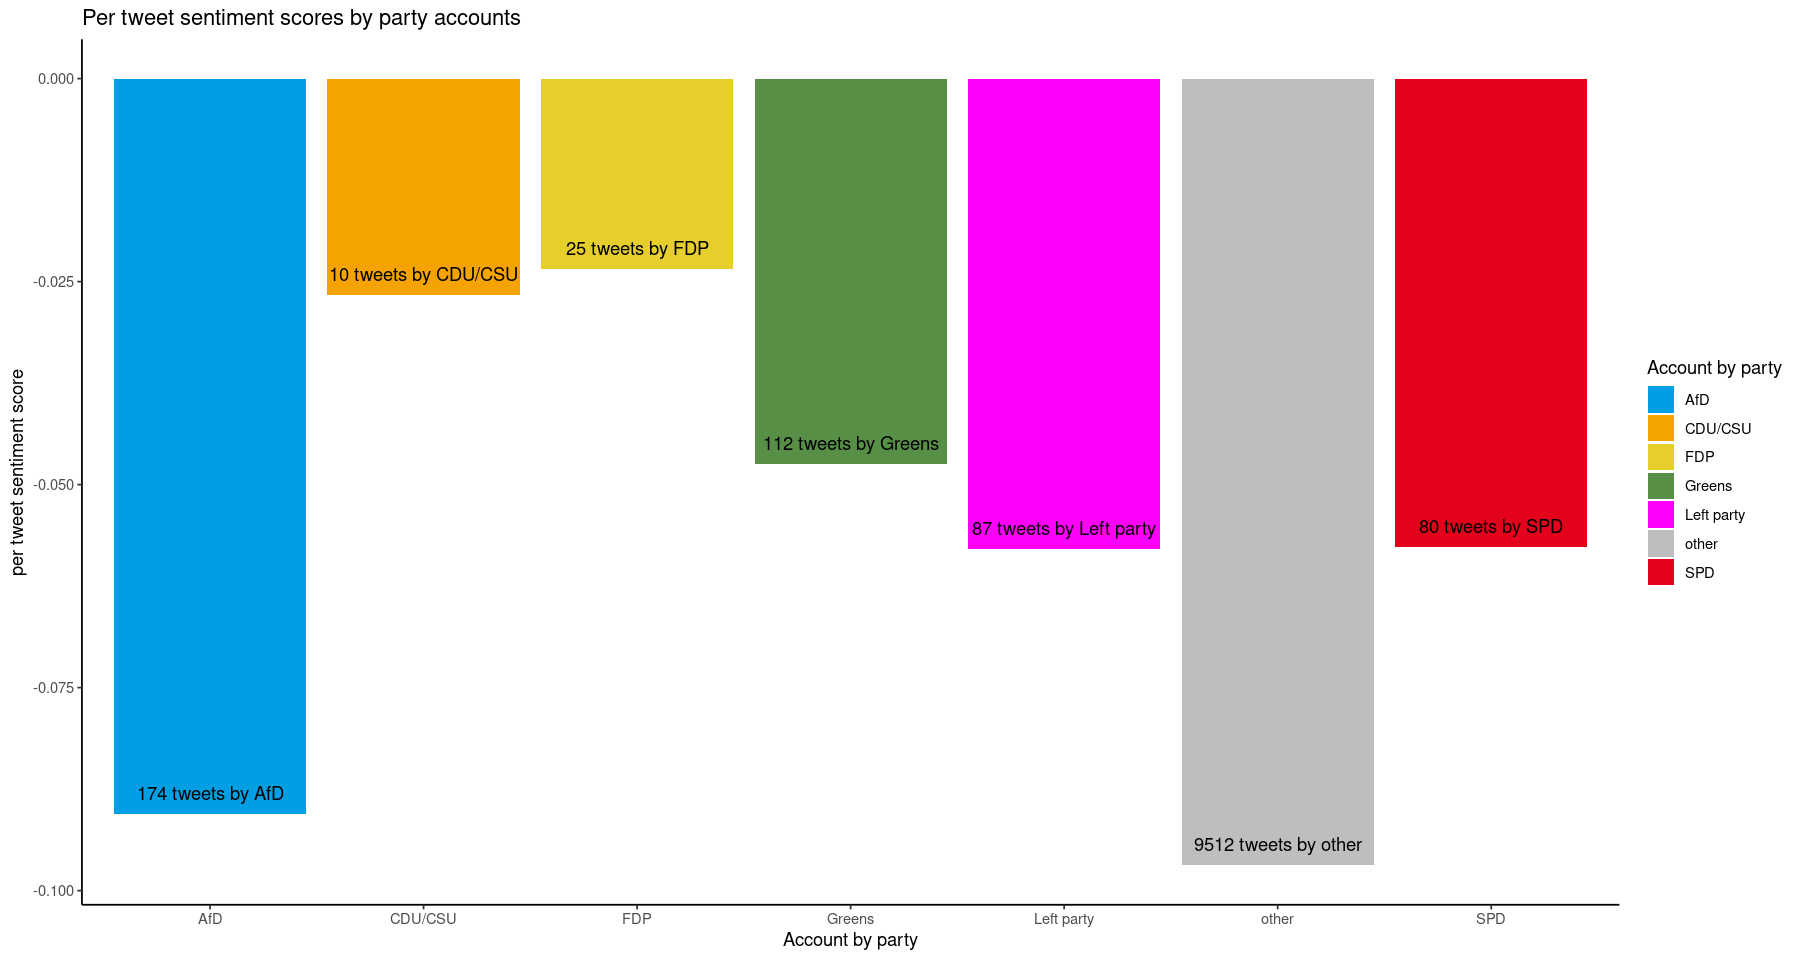

In [12]:
ggplot(data = df_parties,
       aes(x = account_by_party, y = sentiment_per_tweet, fill = account_by_party))+
    geom_bar(stat = "identity")+
    geom_text(aes(y = sentiment_per_tweet, label = paste0(n, " tweets by ", account_by_party)), vjust = -1)+
    theme_classic()+
   scale_fill_manual(values = c("#009EE2", "#F5A301", "#E6CE2C", "#578F46", "#FE00F9",  "grey", "#E4011C"))+
    labs(title = "Per tweet sentiment scores by party accounts",
         y = "per tweet sentiment score",
         x = "Account by party",
        fill = "Account by party")

The plot above depicts the per-tweet-sentiment by accounts that contain the names of the largest German parties in their names. The digits within the bars indicate how many tweets are in the data by accounts mentioning the party names. The category "others" labels all the tweets not by one of the accounts of the parties.

Notably, the overall per-tweet tone in all the groups is negative. But there some interesting patterns in the data:

1. The accounts by the AfD are notably the most negative of all partisan accounts, whereas the accounts by the centre parties of the CDU and the FDP are generally least negative in tone.
2. Almost all parties are less negative in tone than non-partisan users are.
3. The sentiment score of the AfD is quite similar compared to the sentiment in non-partisan accounts.

Although this analysis does not allow any definitve conclusions regarding tweeting-behaviour, it gives a first indication as to varying strategies of the party accounts to either submit a positive message or try to align with negative feelings expressed by non-partisan Twitter users.

## References

*R. Remus, U. Quasthoff & G. Heyer*. **SentiWS - a Publicly Available German-language Resource for Sentiment Analysis.** In: *Proceedings of the 7th International Language Ressources and Evaluation (LREC'10)*, 2010

*Sebastian Stier, Arnim Bleier, Malte Bonart, Fabian Mörsheim, Mahdi Bohlouli, Margarita Nizhegorodov, Lisa Posch, Jürgen Maier, Tobias Rothmund, Steffen Staab*. **Systematically monitoring social media: The case of the German federal election 2017** ([pdf](https://arxiv.org/pdf/1804.02888.pdf), [ZA6926](https://search.gesis.org/research_data/ZA6926))